## Data Gathering

In [1]:
import os
import pandas as pd

# Paths
sensor_data_path = "dataset/users_timeXYZ"
activity_labels_file = "dataset/TrainActivities.csv"

# Step 1: Load Activity Labels
activities = pd.read_csv(activity_labels_file)

In [2]:
activities['Started'] = pd.to_datetime(activities['Started'], format='%Y/%m/%d %H:%M', errors='coerce') \
    .dt.tz_localize('Asia/Tokyo') \
    .dt.tz_convert('UTC')

activities['Finished'] = pd.to_datetime(activities['Finished'], format='%Y/%m/%d %H:%M', errors='coerce') \
    .dt.tz_localize('Asia/Tokyo') \
    .dt.tz_convert('UTC')

activities.head(3)

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-01 21:16:00+00:00,2024-09-01 21:16:00+00:00,2024/09/02 6:16,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-01 21:17:00+00:00,2024-09-01 21:17:00+00:00,2024/09/02 6:17,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-01 21:18:00+00:00,2024-09-01 21:18:00+00:00,2024/09/02 6:18,U22


In [3]:
import os
import pandas as pd
import glob

print("Loading sensor data...")

# Step 2: Load and Collect all sensor file paths
sensor_files = glob.glob(os.path.join(sensor_data_path, "*/*.csv"))
sensor_data_list = []

for file_path in sensor_files:
    # Read sensor data
    df = pd.read_csv(file_path, header=None, names=['RandomID', 'Timestamp', 'X', 'Y', 'Z'])
    
    # Convert timestamp format
    try:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z', utc=True)
    except Exception as e:
        print(f"Error parsing timestamp in {file_path}: {e}")
        continue

    df.drop(columns=['RandomID'], inplace=True)
    sensor_data_list.append(df)

# Combine all sensor data
if sensor_data_list:
    sensor_data = pd.concat(sensor_data_list, ignore_index=True)
    print(f"Total loaded sensor data: {sensor_data.shape}")
else:
    print("No valid sensor data found. Exiting.")
    exit()

# Step 3: Match Sensor Data with Activities by TIMESTAMP
print("Matching sensor data with activity labels...")

matched_data_list = []

for _, activity in activities.iterrows():
    start_time, end_time, subject = activity['Started'], activity['Finished'], activity['Subject']

    # Find sensor data that falls within the activity time window
    mask = (sensor_data['Timestamp'] >= start_time) & (sensor_data['Timestamp'] <= end_time)
    matched_activity_data = sensor_data[mask].copy()
    
    if not matched_activity_data.empty:
        matched_activity_data['Activity'] = activity['Activity Type']
        matched_activity_data['Subject'] = subject  # Keep track of Subject
        matched_data_list.append(matched_activity_data)
        print(f"Matched {len(matched_activity_data)} rows for {activity['Activity Type']} (Subject {subject}).")

os.makedirs('processed data', exist_ok=True)

# Step 4: Save Final Matched Data
if matched_data_list:
    final_data = pd.concat(matched_data_list, ignore_index=True)
    print(f"Final matched data shape: {final_data.shape}")
    final_data.to_csv("processed data/Matched_Sensor_Activities.csv", index=False)
    print("Saved matched sensor data.")
else:
    print("No matching sensor data found for any activities.")

print("Processing complete.")


Loading sensor data...
Total loaded sensor data: (2045326, 4)
Matching sensor data with activity labels...
Matched 450 rows for 2 (FACING camera) both hands SHAKING (sitting position) (Subject U22).
Matched 451 rows for 3 Stand up from chair - both hands with SHAKING (Subject U22).
Matched 459 rows for 4 (Sideway) Sit & stand (Subject U22).
Matched 450 rows for 5 (Sideway) both hands SHAKING (sitting) (Subject U22).
Matched 450 rows for 6 (Sideway) STAND up with - both hands SHAKING (Subject U22).
Matched 551 rows for 9 Walk & STOP/frozen, full body shaking, rotate then return back (Subject U22).
Matched 552 rows for 10 Slow walk (SHAKING hands/body, tiny step, head forward) (Subject U22).
Matched 450 rows for 10 Slow walk (SHAKING hands/body, tiny step, head forward) (Subject U22).
Matched 550 rows for 10 Slow walk (SHAKING hands/body, tiny step, head forward) (Subject U22).
Matched 449 rows for 3 Stand up from chair - both hands with SHAKING (Subject U21).
Matched 499 rows for 6 (Sid

In [4]:
sensor_data.to_csv("processed data/AllSensorData.csv", index=False)

## Loading Dataset

In [5]:
import os
import pandas as pd

In [6]:
data = pd.read_csv("processed data/Matched_Sensor_Activities.csv")
data.head(3)

,Timestamp,X,Y,Z,Activity,Subject
0,2024-09-03 10:56:00.067000+00:00,-0.646,4.516,8.696,2 (FACING camera) both hands SHAKING (sitting ...,U22
1,2024-09-03 10:56:00.202000+00:00,-0.682,4.463,8.680,2 (FACING camera) both hands SHAKING (sitting ...,U22
2,2024-09-03 10:56:00.335000+00:00,-0.730,4.458,8.703,2 (FACING camera) both hands SHAKING (sitting ...,U22


## Info

In [7]:
data.shape

(104627, 6)

In [8]:
data.columns

Index(['Timestamp', 'X', 'Y', 'Z', 'Activity', 'Subject'], dtype='object')

In [9]:
data['Subject'].value_counts()

Subject
U3     36200
U6     33883
U7     12579
U5      5188
U4      4831
U22     4363
U2      3583
U21     2131
U1      1869
Name: count, dtype: int64

In [10]:
num_classes = len(data['Activity'].value_counts())
num_classes

10

## Preprcoessing Dataset

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Encode activity labels
label_encoder = LabelEncoder()
data['Activity_Label'] = label_encoder.fit_transform(data['Activity'])

# Normalize sensor values
scaler = StandardScaler()
data[['X', 'Y', 'Z']] = scaler.fit_transform(data[['X', 'Y', 'Z']])

# Group by Subject & Create Sequences
time_window = 10  # 10 sensor readings per sequence
sequences = []
labels = []

for subject, group in data.groupby('Subject'):
    group = group.sort_values('Timestamp')
    sensor_values = group[['X', 'Y', 'Z']].values
    activity_labels = group['Activity_Label'].values
    
    for i in range(len(group) - time_window):
        sequences.append(sensor_values[i:i+time_window])
        labels.append(activity_labels[i + time_window])

sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and validation sets (80%-20%) using numpy arrays first
X_train, X_val, y_train, y_val = train_test_split(
    sequences, labels, test_size=0.2, random_state=42, shuffle=True
)

# Then convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int32)

# Optionally create TensorFlow Datasets for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor)).batch(32).shuffle(buffer_size=1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor)).batch(32)

### Saving Files

In [12]:
np.save("label_classes.npy", label_encoder.classes_)
import pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## Models

#### Transformer Model

**Model Building**

In [13]:
from tensorflow.keras import layers, models, Layer
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(d_model),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "d_model": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,
        })
        return config


def create_transformer_model(input_dim=3, seq_len=10, num_classes=num_classes, d_model=64, num_heads=4, num_layers=2):
    inputs = tf.keras.Input(shape=(seq_len, input_dim))  # Shape: (batch, time, features)

    # Linear embedding (like nn.Linear in PyTorch)
    x = layers.Dense(d_model)(inputs)

    # Transformer Encoder Blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model=d_model, num_heads=num_heads, ff_dim=128)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Final Classification Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

**Model Creation**

In [14]:
# Create the model
transformer_model = create_transformer_model(
    input_dim=3,  # X, Y, Z features
    seq_len=10,   # Your time_window size
    num_classes=num_classes,  # Number of unique activities
    d_model=64,
    num_heads=4,
    num_layers=2
)

**Model Compilation**

In [15]:
# Compile the model
transformer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Model Checkpoint**

In [16]:
# Callbacks: EarlyStopping and ModelCheckpoint
transformer_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

transformer_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained_transformer_model.keras', monitor='val_loss', save_best_only=True, verbose=1
)

**Model Training**

In [21]:
# Fit the model
transformer_history = transformer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[transformer_early_stop, transformer_checkpoint]
)

Epoch 1/50
2611/2614 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6054 - loss: 1.0509
Epoch 1: val_loss did not improve from 1.03300
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6055 - loss: 1.0509 - val_accuracy: 0.6125 - val_loss: 1.0412
Epoch 2/50
2613/2614 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6099 - loss: 1.0419
Epoch 2: val_loss did not improve from 1.03300
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.6099 - loss: 1.0418 - val_accuracy: 0.6173 - val_loss: 1.0383
Epoch 3/50
2609/2614 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6136 - loss: 1.0263
Epoch 3: val_loss improved from 1.03300 to 1.01717, saving model to trained_transformer_model.keras
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6136 - loss: 1.0263 - val_accuracy: 0.6233 - val_loss: 1.0172
Epoch 4/50
2611/2614 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6181 - loss: 1.0145
Epoch 4: val_loss improved from 1.01717 to 1.01053, saving model to trained_transformer_m

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Evaluate on validation set
val_loss, val_accuracy = transformer_model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = transformer_model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Collect true labels from validation dataset
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Compute Accuracy (again for consistency)
acc = accuracy_score(y_true, y_pred)
print(f"Sklearn Accuracy: {acc:.4f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7015 - loss: 0.8317
Validation Loss: 0.8423
Validation Accuracy: 0.6997
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Sklearn Accuracy: 0.6997

Classification Report:
                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.75      0.60      0.67        88
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.79      0.74      0.76      5035
         2 (FACING camera) both hands SHAKING (sitting position)       0.78      0.80      0.79      2090
                 3 Stand up from chair - both hands with SHAKING       0.70      0.66      0.68      2179
                                         4 (Sideway) Sit & stand       0.60      0.55      0.58      1543
                        5 (Sideway) both hands SHAKING (sitting)       0.60      0.73      0.66      1335
                  6 (Sideway) STAND up w

**Accuracy Plotting**

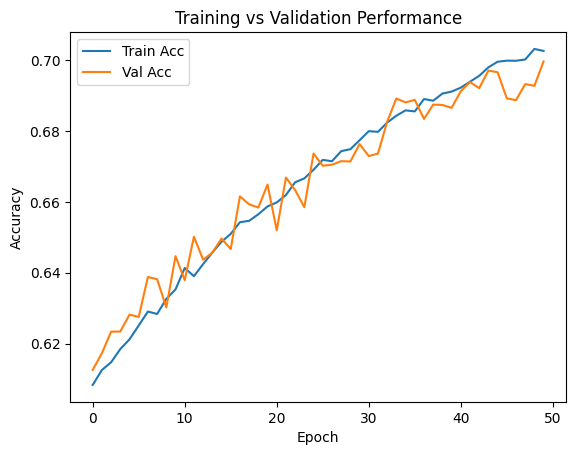

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy 
plt.plot(transformer_history.history['accuracy'], label='Train Acc')
plt.plot(transformer_history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Performance")
plt.show()

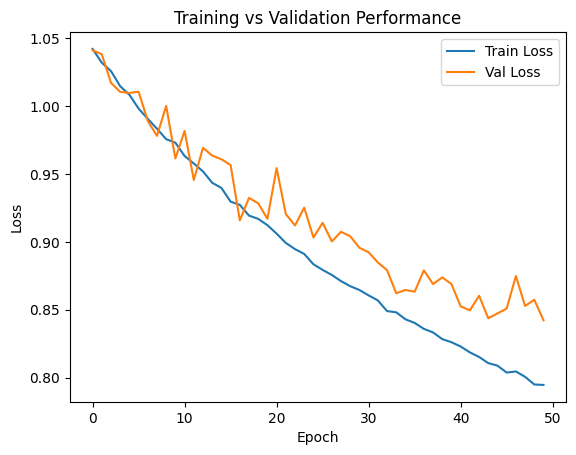

In [26]:
# Plot loss
plt.plot(transformer_history.history['loss'], label='Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Performance")
plt.show()

In [24]:
transformer_model.save('trained_transformer_model.keras')